In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ============================================================
# 1. Load Data
# ============================================================
covid_confirmed = pd.read_csv("/Users/jannatrahman/your_project/data/covid19_Confirmed_dataset.csv")
covid_deaths    = pd.read_csv("/Users/jannatrahman/your_project/data/covid19_deaths_dataset.csv")
happiness       = pd.read_csv("/Users/jannatrahman/your_project/data/worldwide_happiness_report.csv")


In [3]:
# ============================================================
# 2. Reshape COVID Confirmed + Deaths
# ============================================================
covid_confirmed_long = covid_confirmed.melt(
    id_vars=["Province/State","Country/Region","Lat","Long"],
    var_name="date",
    value_name="confirmed"
)
covid_deaths_long = covid_deaths.melt(
    id_vars=["Province/State","Country/Region","Lat","Long"],
    var_name="date",
    value_name="deaths"
)

# Merge confirmed + deaths
covid_long = pd.merge(
    covid_confirmed_long,
    covid_deaths_long[["Country/Region","Province/State","date","deaths"]],
    on=["Country/Region","Province/State","date"],
    how="left"
)

# Convert date to datetime
covid_long["date"] = pd.to_datetime(covid_long["date"], errors="coerce")

# Drop rows where date couldn't be parsed
covid_long = covid_long.dropna(subset=["date"])

# Extract year
covid_long["year"] = covid_long["date"].dt.year


/var/folders/93/1qy42t2d0_11xmztn26_hq840000gn/T/ipykernel_1224/3767665498.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_long["date"] = pd.to_datetime(covid_long["date"], errors="coerce")


In [4]:
# ============================================================
# 3. Aggregate yearly COVID stats per country
# ============================================================
covid_yearly = covid_long.groupby(["Country/Region","year"]).agg({
    "confirmed":"max",
    "deaths":"max"
}).reset_index()

In [5]:
# ============================================================
# 4. Clean Happiness Data
# ============================================================
# Standardize column names
happiness = happiness.rename(columns={
    "Country or region":"Country/Region",
    "Overall rank":"overall_rank",
    "Score":"score",
    "GDP per capita":"gdp_per_capita",
    "Social support":"social_support",
    "Healthy life expectancy":"healthy_life_expectancy",
    "Freedom to make life choices":"freedom_to_make_life_choices",
    "Generosity":"generosity",
    "Perceptions of corruption":"perceptions_of_corruption"
})
happiness["year"] = 2020   # this dataset is only for 2020


In [6]:
# ============================================================
# 5. Merge COVID + Happiness
# ============================================================
merged = pd.merge(
    covid_yearly,
    happiness,
    on=["Country/Region","year"],
    how="inner"
)

print("\n=== MERGED DATA SAMPLE ===")
print(merged.head())
print("Shape:", merged.shape)



=== MERGED DATA SAMPLE ===
  Country/Region  year  confirmed  deaths  overall_rank  score  \
0    Afghanistan  2020       2171      64           154  3.203   
1        Albania  2020        773      31           107  4.719   
2        Algeria  2020       4006     450            88  5.211   
3      Argentina  2020       4428     218            47  6.086   
4        Armenia  2020       2066      32           116  4.559   

   gdp_per_capita  social_support  healthy_life_expectancy  \
0           0.350           0.517                    0.361   
1           0.947           0.848                    0.874   
2           1.002           1.160                    0.785   
3           1.092           1.432                    0.881   
4           0.850           1.055                    0.815   

   freedom_to_make_life_choices  generosity  perceptions_of_corruption  
0                         0.000       0.158                      0.025  
1                         0.383       0.178             

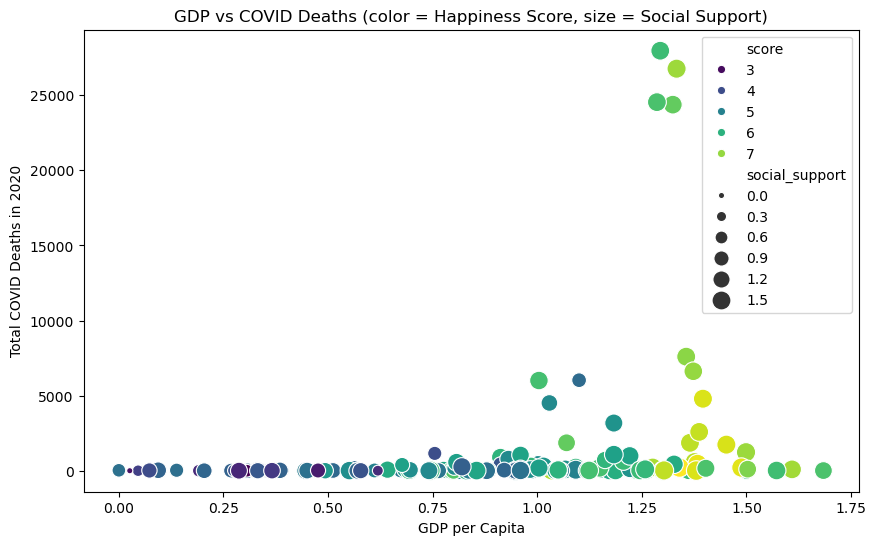

In [7]:
# ============================================================
# 6. Example Visualization
# ============================================================
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged,
    x="gdp_per_capita",
    y="deaths",
    hue="score",
    size="social_support",
    sizes=(20,200),
    palette="viridis"
)
plt.title("GDP vs COVID Deaths (color = Happiness Score, size = Social Support)")
plt.xlabel("GDP per Capita")
plt.ylabel("Total COVID Deaths in 2020")
plt.show()